# Test trained neural density estimator

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from models import WF, WF_bottleneck, WF_DFE, WF_FD
import pickle

In [2]:
from sbi.inference import RejectionPosterior
from inference_utils import get_prior
# Load the posterior and test data
with open('posteriors/posterior.pkl', 'rb') as f:
    posterior = pickle.load(f)

X = pd.read_csv('test_sims/WF_sims.csv')
theta = pd.read_csv('test_sims/WF_thetas.csv')

# Realistic test
theta = theta[X.iloc[:,-1] > 0.2]
X = X[X.iloc[:,-1] > 0.2]



In [25]:
%%capture
# Test function - accuracy
# Compare sample mean to true parameter
def test_estimator(posterior, X, theta,output_file_name='test_results.csv', export = False):
    output_data = pd.DataFrame(columns = ['s','mu'], index = [i for i in range(len(theta))])
    for i in range(len(X)):
        xi = X.iloc[i,:]
        true_param = theta.iloc[i,:]
        samps = posterior.set_default_x(xi).sample((100,))
        m = np.array(samps.mean(0))
        # m = np.array(posterior.set_default_x(xi).map(num_iter=100))[0]
        output_data.iloc[i,:] = m-true_param
    if export:
        output_data.to_csv(output_file_name)
    return output_data

test_results = test_estimator(posterior, X, theta, export = True, output_file_name='test_results.csv')

<>:7: SyntaxWarning: invalid escape sequence '\m'
<>:7: SyntaxWarning: invalid escape sequence '\m'
C:\Users\nadav\AppData\Local\Temp\ipykernel_28868\2268780431.py:7: SyntaxWarning: invalid escape sequence '\m'
  ax[1].set_xlabel('$\mu$')


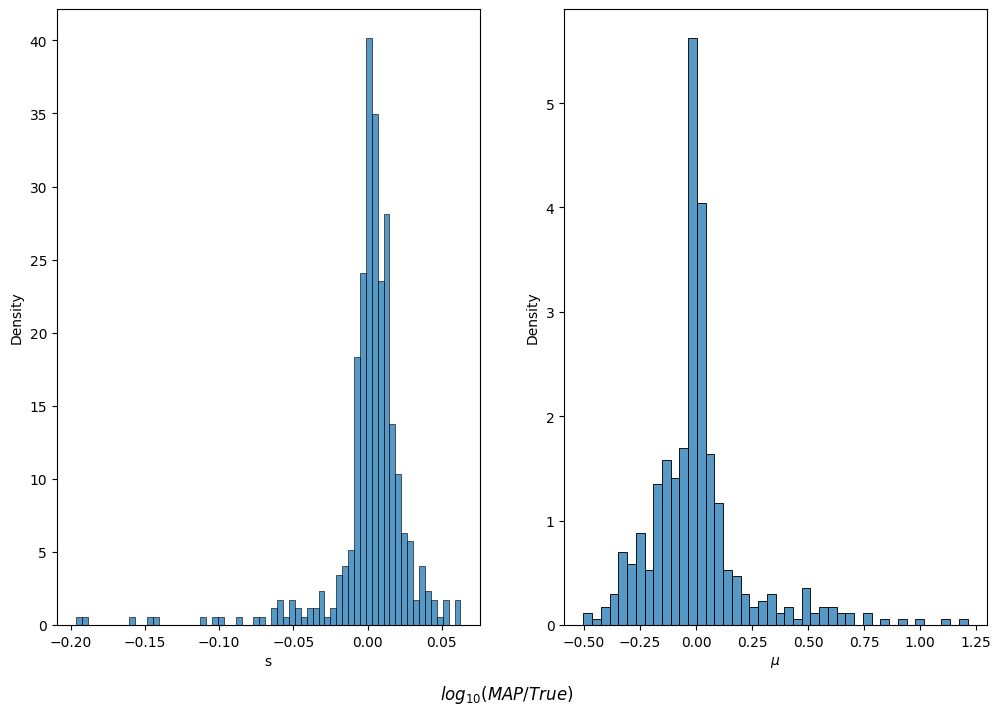

In [4]:
def plot_test_results(test_results):
    fig, ax = plt.subplots(1,2, figsize=(12,8))
    sns.histplot(test_results['s'], ax = ax[0], stat='density')
    sns.histplot(test_results['mu'], ax = ax[1], stat='density')
    fig.supxlabel('$log_{10}({MAP}/{True})$')
    ax[0].set_xlabel('s')
    ax[1].set_xlabel('$\mu$')
plot_test_results(test_results)

In [5]:
%%capture
# Fast coverage function
import torch
def coverage(posterior, X, theta):
    covs = []
    for i in range(len(X)):
        samples = posterior.set_default_x(X.iloc[i,:]).sample((200,))
        params = torch.tensor(theta.iloc[i,:], dtype=torch.float32)
        covs.append((posterior.log_prob(samples) > posterior.log_prob(params)).sum()/200)
    return np.array(covs)

covs = coverage(posterior, X, theta)

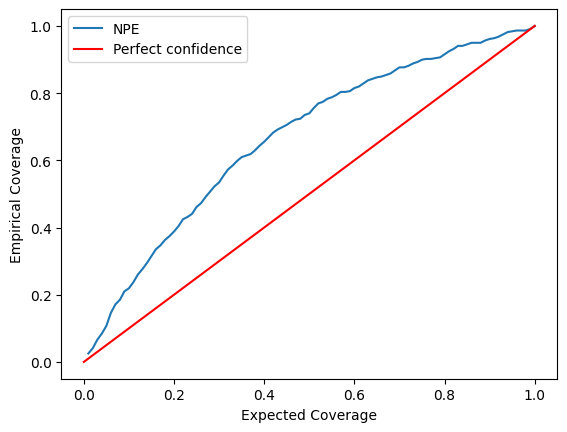

In [6]:
def plot_coverage(covs):
    H,X1 = np.histogram(covs, bins = 100, range = (0,1), density = True)
    dx = X1[1] - X1[0]
    F1 = np.cumsum(H)*dx
    plt.plot(X1[1:], F1, label = 'NPE')
    plt.plot(np.linspace(0,1,100),np.linspace(0,1,100), color='red', label='Perfect confidence')
    plt.xlabel('Expected Coverage')
    plt.ylabel('Empirical Coverage')
    plt.legend()
plot_coverage(covs)

In [7]:
%%capture
# Test on simulations from another model - DFE

X_DFE = pd.read_csv('test_sims/WF_DFE_sims.csv').iloc[:400,:]
theta_DFE = pd.read_csv('test_sims/WF_DFE_thetas.csv').iloc[:400,:]
theta = pd.read_csv('test_sims/WF_DFE_thetas.csv').iloc[:400,:]
# Realistic test
theta_DFE = theta[X_DFE.iloc[:,-1] > 0.2]
X_DFE = X_DFE[X_DFE.iloc[:,-1] > 0.2]

test_results_DFE = test_estimator(posterior, X_DFE, theta_DFE, output_file_name='test_results_DFE.csv')

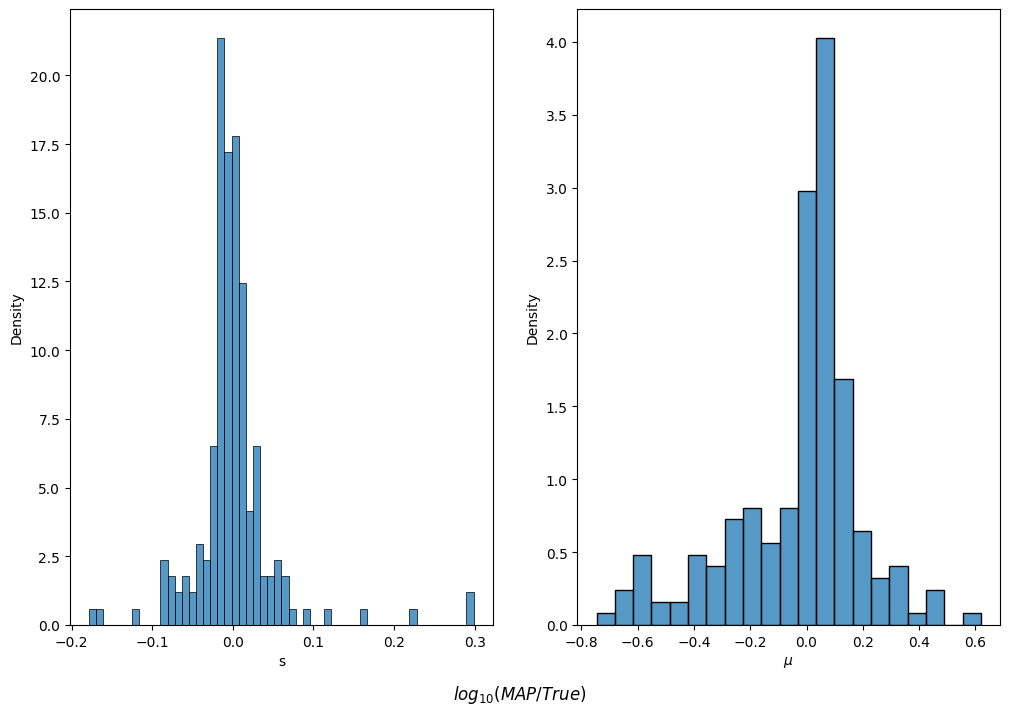

In [8]:
plot_test_results(test_results_DFE)

In [9]:
%%capture
covs_DFE = coverage(posterior, X_DFE, theta_DFE)

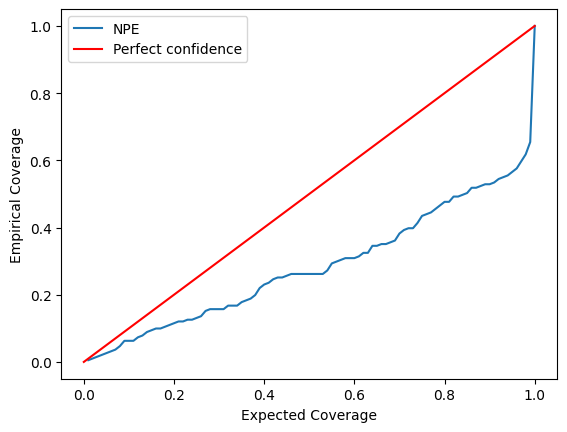

In [10]:
plot_coverage(covs_DFE)

In [11]:
%%capture
# Test on simulations from another model - bottleneck

X_bottleneck = pd.read_csv('test_sims/WF_bottleneck_sims.csv')
theta_bottleneck = pd.read_csv('test_sims/WF_bottleneck_thetas.csv')
# Realistic test
theta_bottleneck = theta_bottleneck[X_bottleneck.iloc[:,-1] > 0.2]
X_bottleneck = X_bottleneck[X_bottleneck.iloc[:,-1] > 0.2]

test_results_bottleneck = test_estimator(posterior, X_bottleneck, theta_bottleneck, output_file_name='test_results_bottleneck.csv')

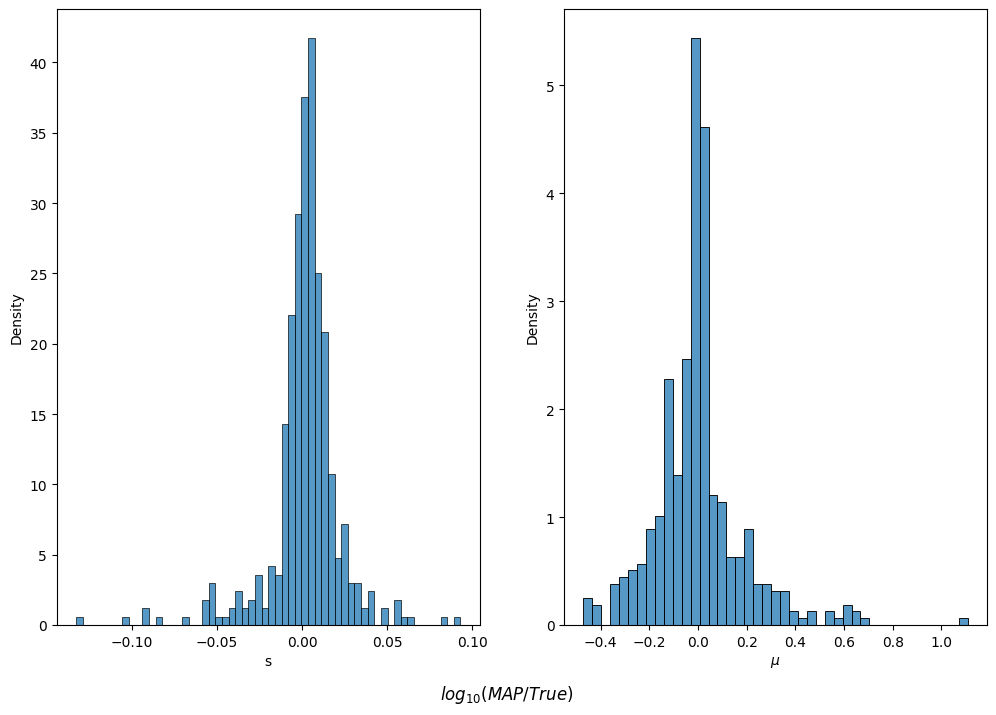

In [18]:
plot_test_results(test_results_bottleneck)

In [14]:
%%capture
X_bottleneck = pd.read_csv('test_sims/WF_bottleneck_sims.csv')
theta_bottleneck = pd.read_csv('test_sims/WF_bottleneck_thetas.csv')
covs_bottleneck = coverage(posterior, X_bottleneck, theta_bottleneck)

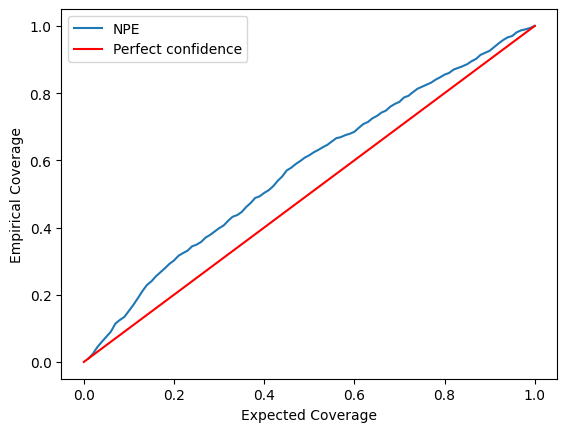

In [15]:
plot_coverage(covs_bottleneck)

In [31]:
# %%capture
# Test on simulations from another model - frequency-dependent selection
posterior = RejectionPosterior(posterior.potential_fn, proposal=get_prior())
X_FD = pd.read_csv('test_sims/WF_FD_sims.csv')
theta_FD = pd.read_csv('test_sims/WF_FD_thetas.csv')
# Realistic test
theta_FD = theta_FD[X_FD.iloc[:,-1] > 0.2].iloc[5:]
X_FD = X_FD[X_FD.iloc[:,-1] > 0.2].iloc[5:]

test_results_FD = test_estimator(posterior, X_FD, theta_FD, output_file_name='test_results_FD.csv')

c:\Users\nadav\AppData\Local\Programs\Python\Python312\Lib\site-packages\sbi\utils\user_input_checks.py:584: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = atleast_2d(torch.as_tensor(x, dtype=float32))


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

c:\Users\nadav\AppData\Local\Programs\Python\Python312\Lib\site-packages\sbi\utils\user_input_checks.py:584: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = atleast_2d(torch.as_tensor(x, dtype=float32))


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

Optimization was interrupted after 48 iterations. 


Drawing 100 posterior samples:   0%|          | 0/100 [00:00<?, ?it/s]

In [1]:
plot_test_results(test_results_FD)

NameError: name 'plot_test_results' is not defined

In [ ]:
%%capture
covs_FD = coverage(posterior, X_FD, theta_FD)

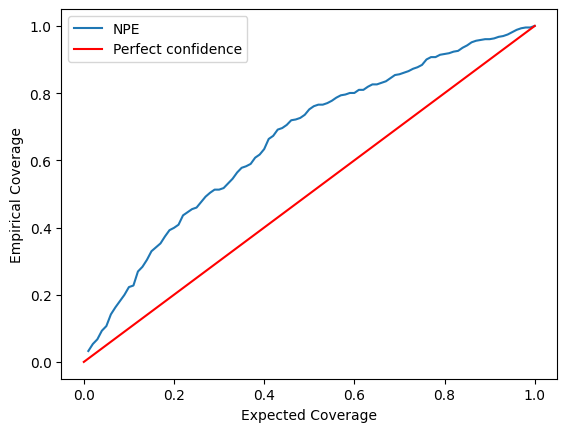

In [ ]:
plot_coverage(covs_FD)